The following is a modification of the Jupyter notebook attached here: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Some environment variable 'libiomp5md.dll' is causing kernel crashes, this is just to fix it for now.

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [ ]:
# create a transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the EuroSAT datasets
path = '~/EuroSAT_DL'
train_dataset = EuroSAT(path, transform=transform,download=True)
test_dataset  = EuroSAT(path, transform=transform,download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

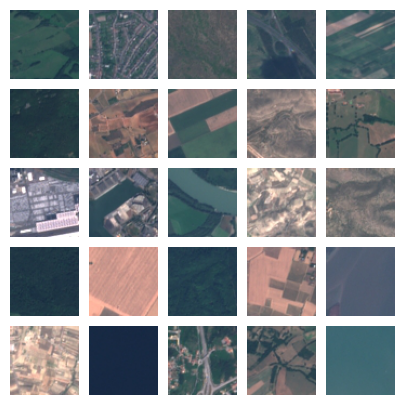

In [ ]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)
num_samples = 25
sample_images = [image[0][i].permute(1,2,0) for i in range(num_samples)] 
# The permutation changes the dimension of the data from 3x64x64 to 64x64x3, makes it easier to work with.

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im)
    ax.axis('off')

plt.show()

In [ ]:
class Encoder(nn.Module):

    def __init__(self, input_dim=12288, hidden_dim=512, latent_dim=256): # 12288 = 64*64*3
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [10]:
class Decoder(nn.Module):

    def __init__(self, output_dim=12288, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [11]:
class VAE(nn.Module):

    def __init__(self, input_dim=12288, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [12]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [13]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [14]:
def train(model, optimizer, epochs, device, x_dim=64*64*3):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [11]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  7823.401798327138
	Epoch 2 	Average Loss:  7727.208064591078
	Epoch 3 	Average Loss:  7723.1631737918215
	Epoch 4 	Average Loss:  7720.939079925651
	Epoch 5 	Average Loss:  8065.7002393122675
	Epoch 6 	Average Loss:  7731.067274628253
	Epoch 7 	Average Loss:  7725.839430762082
	Epoch 8 	Average Loss:  7723.93436105948
	Epoch 9 	Average Loss:  7723.050543680298
	Epoch 10 	Average Loss:  7722.276698420074
	Epoch 11 	Average Loss:  7722.553043680297
	Epoch 12 	Average Loss:  7721.346322026022
	Epoch 13 	Average Loss:  7722.310088289963
	Epoch 14 	Average Loss:  7720.606628717472
	Epoch 15 	Average Loss:  7720.327026022304
	Epoch 16 	Average Loss:  7719.465211431227
	Epoch 17 	Average Loss:  7719.542072490706
	Epoch 18 	Average Loss:  7719.001603159852
	Epoch 19 	Average Loss:  7718.977973977695
	Epoch 20 	Average Loss:  7718.216816914498
	Epoch 21 	Average Loss:  7718.150220724907
	Epoch 22 	Average Loss:  7717.661194237919
	Epoch 23 	Average Loss:  7716.977304832

208148890.625

In [ ]:
def generate_image(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    # What does mean/var actually imply here? Worth looking into and noting for later.
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(64, 64, 3) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit)
    plt.axis('off')
    plt.show()

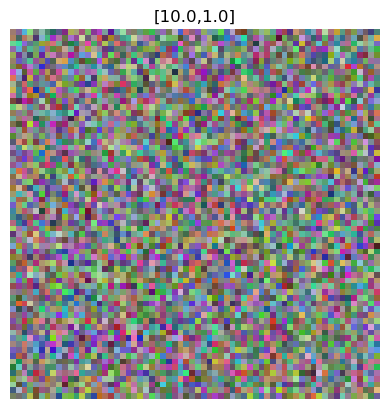

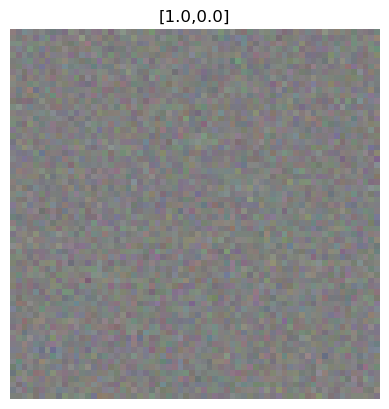

(None, None)

In [ ]:
#img1: mean0, var1 / img2: mean1, var0
generate_image(10.0, 1.0), generate_image(1.0, 0.0)
# This just makes static as of now. Adam recommended a convolutional network for the VAE to improve upon this.

In [18]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=64, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(64, 64)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [19]:
plot_latent_space(model, scale=1.0)

RuntimeError: shape '[64, 64]' is invalid for input of size 12288

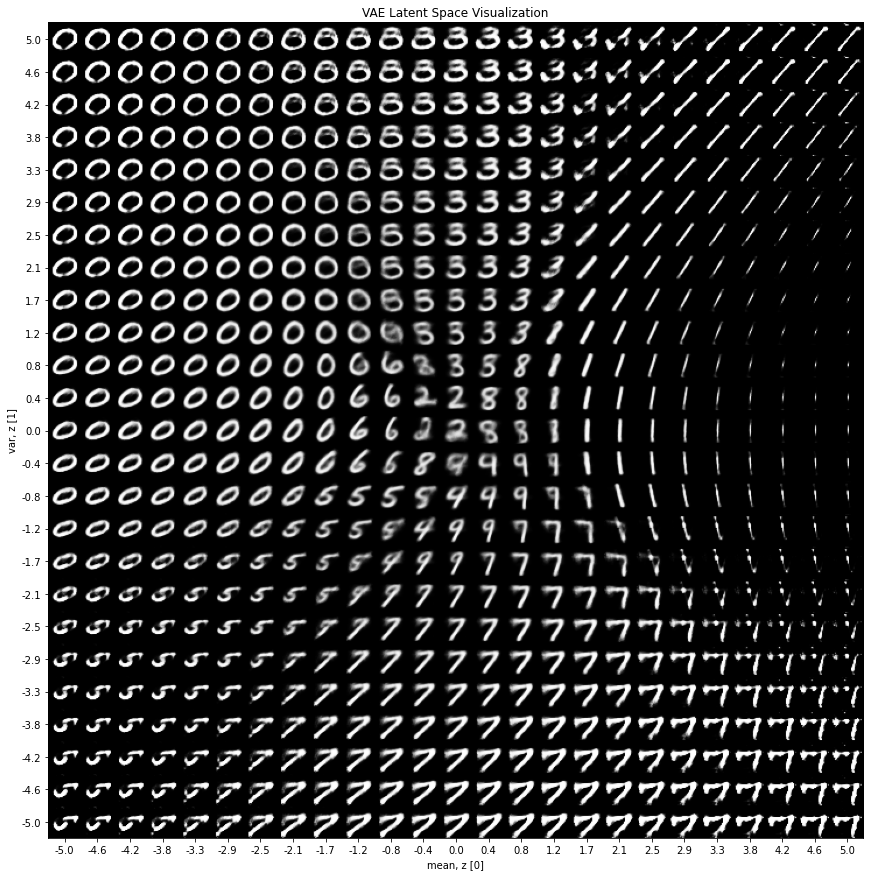

In [ ]:
plot_latent_space(model, scale=5.0)